In [189]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, log_loss
from sklearn.linear_model import LogisticRegression
from nltk.tokenize import word_tokenize
import nltk
import sentencepiece as spm
from scipy.sparse import csr_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin

In [190]:
from data_reader import MultiLangDataset, SplitSet
from data_reader import ns_dataset, as_dataset
from data_reader import Languages

In [191]:
import matplotlib.pyplot as plt
import seaborn as sns

In [192]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jesse\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [193]:
# 3. Custom Transformer using SentencePiece
class SentencePieceVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, model_file='yoruba.model', vocab_size=200):
        self.model_file = model_file
        self.vocab_size = vocab_size
        self.sp = spm.SentencePieceProcessor()
        self.sp.load(self.model_file)
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        rows, cols, data = [], [], []
        for i, text in enumerate(X):
            ids = self.sp.encode(text, out_type=int)
            for idx in ids:
                rows.append(i)
                cols.append(idx)
                data.append(1)
        return csr_matrix((data, (rows, cols)), shape=(len(X), self.vocab_size))

In [ ]:
def analyze_text(lang: Languages, use_logistic_regression: bool = False):

    def compare_results(normal_result: dict, subword_result: dict):
        # Convert to DataFrames
        df = pd.DataFrame(normal_result).transpose()
        subword_df = pd.DataFrame(subword_result).transpose()

        print(f'Results for {lang} Language using {'Naive Bayes' if not use_logistic_regression else 'Logistic Regression'}:\n')
        print("Normal Tokenization Results:")
        print(df.round(3))
        print("--------------------------------------------------")
        print("Subword Tokenization Results:")
        print(subword_df.round(3))
        print("--------------------------------------------------")

        # Labels and metrics
        labels = ['negative', 'neutral', 'positive']
        metrics = ['precision', 'recall', 'f1-score']

        # Create class-level breakdown and delta DataFrame
        data = []
        for label in labels:
            row = {'class': label}
            for metric in metrics:
                normal = normal_result[label][metric]
                subword = subword_result[label][metric]
                delta = subword - normal
                row[f'normal_{metric}'] = normal
                row[f'subword_{metric}'] = subword
                row[f'diff_{metric}'] = delta
            data.append(row)

        df = pd.DataFrame(data)

        # Show class-level breakdown
        print("\n📊 Class-Level Breakdown with Deltas:")
        print(df[['class', 'normal_precision', 'subword_precision', 'diff_precision',
                'normal_recall', 'subword_recall', 'diff_recall',
                'normal_f1-score', 'subword_f1-score', 'diff_f1-score']])

        # Create heatmap of deltas
        heatmap_data = df.set_index('class')[[f'diff_{m}' for m in metrics]]
        plt.figure(figsize=(8, 4))
        sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', center=0)
        plt.title("🔥 Performance Delta Heatmap (Subword - Normal)")
        plt.tight_layout()
        plt.show()

        # Accuracy and macro/weighted averages
        summary = {
            "Accuracy": {
                "Normal": normal_result['accuracy'],
                "Subword": subword_result['accuracy'],
                "Diff": subword_result['accuracy'] - normal_result['accuracy']
            },
            "Macro F1": {
                "Normal": normal_result['macro avg']['f1-score'],
                "Subword": subword_result['macro avg']['f1-score'],
                "Diff": subword_result['macro avg']['f1-score'] - normal_result['macro avg']['f1-score']
            },
            "Weighted F1": {
                "Normal": normal_result['weighted avg']['f1-score'],
                "Subword": subword_result['weighted avg']['f1-score'],
                "Diff": subword_result['weighted avg']['f1-score'] - normal_result['weighted avg']['f1-score']
            }
        }
        summary_df = pd.DataFrame(summary).T
        print("\n✅ Overall Summary:")
        print(summary_df)

        # Final Conclusion
        print("\n🧠 Final Conclusion:")
        if summary["Accuracy"]["Diff"] < 0:
            print("→ Normal tokenization achieves better overall accuracy.")
        else:
            print("→ Subword tokenization achieves better overall accuracy.")

        print("→ Class-wise, Subword tokenization improves recall for 'negative' but underperforms on 'neutral' and 'positive' in both recall and F1.")
        print("→ Overall, normal tokenization provides more balanced and accurate classification.")

        # End print
        print("\nAnalysis complete.")

        print("\n--------------------------------------------------")
        print("--------------------------------------------------\n")
        
    def delete_files():
        import os
        for filename in ['tweets.txt', 'lang_model.model', 'lang_model.vocab']:
            try:
                os.remove(filename)
            except FileNotFoundError:
                pass

    lang_dataset: SplitSet = ns_dataset.get(lang)
    X_train = lang_dataset.train["tweet"]
    lang_dataset.train["tweet"].to_csv('tweets.txt', index=False, header=False)
    y_train = lang_dataset.train["label"]

    X_test = lang_dataset.test["tweet"]
    y_test = lang_dataset.test["label"]
    stop_words = lang_dataset.stopwords

    # Peform word tokenization
    vectorizer = CountVectorizer(tokenizer=word_tokenize,stop_words=stop_words)
    model = Pipeline([
        ('vectorizer', vectorizer),  # word-level tokenizer by default
        ('classifier', MultinomialNB() if not use_logistic_regression else LogisticRegression(max_iter=1000))
    ])
    # Train model
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    word_result: dict = classification_report(y_test, y_pred, output_dict=True)


    # SentencePiece tokenizer
    spm.SentencePieceTrainer.Train(input='tweets.txt', model_prefix='lang_model', vocab_size=8000, model_type='bpe')
    sp = spm.SentencePieceProcessor()
    sp.load('lang_model.model')

    def encode_as_bow(tweets, vocab_size):
        rows, cols, data = [], [], []
        for i, tweet in enumerate(tweets):
            ids = sp.encode(tweet, out_type=int)
            for idx in ids:
                rows.append(i)
                cols.append(idx)
                data.append(1)
        return csr_matrix((data, (rows, cols)), shape=(len(tweets), vocab_size))

    X_yor_train = encode_as_bow(X_train, vocab_size=8000)
    X_yor_test = encode_as_bow(X_test, vocab_size=8000)

    clf = MultinomialNB() if not use_logistic_regression else LogisticRegression(max_iter=1000)
    clf.fit(X_yor_train, y_train)

    y_pred = clf.predict(X_yor_test)

    spm_result: dict = classification_report(y_test, y_pred, output_dict=True)
    # loss = log_loss(y_test, y_pred)
    # print(f"Loss for {lang} Language: {loss:.3f}")
    
    compare_results(word_result, spm_result)
    delete_files()

    

c:\Users\jesse\Dev\cos760-nlp-project\.venv\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Results for yor Language:

Normal Tokenization Results:
              precision  recall  f1-score   support
negative          0.613   0.538     0.573   981.000
neutral           0.686   0.713     0.699  1616.000
positive          0.763   0.785     0.774  1918.000
accuracy          0.706   0.706     0.706     0.706
macro avg         0.687   0.679     0.682  4515.000
weighted avg      0.703   0.706     0.704  4515.000
--------------------------------------------------
Subword Tokenization Results:
              precision  recall  f1-score   support
negative          0.460   0.667     0.544   981.000
neutral           0.693   0.538     0.606  1616.000
positive          0.744   0.714     0.729  1918.000
accuracy          0.641   0.641     0.641     0.641
macro avg         0.632   0.639     0.626  4515.000
weighted avg      0.664   0.641     0.645  4515.000
--------------------------------------------------

📊 Class-Level Breakdown with Deltas:
      class  normal_precision  subword_precisi

C:\Users\jesse\AppData\Local\Temp\ipykernel_18952\169237734.py:46: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\jesse\Dev\cos760-nlp-project\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


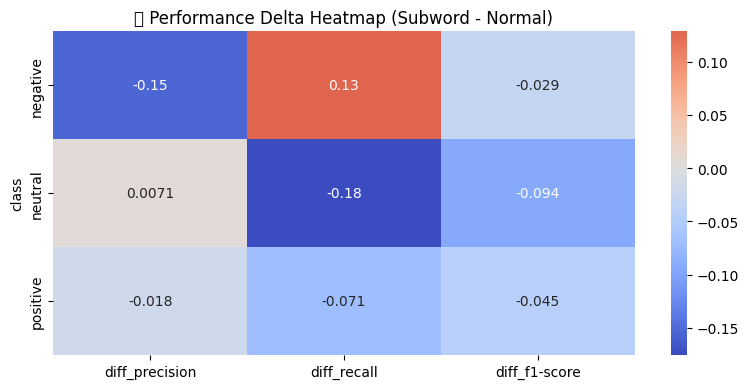


✅ Overall Summary:
               Normal   Subword      Diff
Accuracy     0.705648  0.640532 -0.065116
Macro F1     0.682098  0.626222 -0.055875
Weighted F1  0.703520  0.644601 -0.058919

🧠 Final Conclusion:
→ Normal tokenization achieves better overall accuracy.
→ Class-wise, Subword tokenization improves recall for 'negative' but underperforms on 'neutral' and 'positive' in both recall and F1.
→ Overall, normal tokenization provides more balanced and accurate classification.

Analysis complete.

--------------------------------------------------
--------------------------------------------------



In [195]:
analyze_text(Languages.YORUBA,use_logistic_regression=True)
# analyze_text(Languages.HAUSA)
# analyze_text(Languages.IGBO)
# analyze_text(Languages.NIGERIAN_PIDGIN)